In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import geopandas as gpd

%matplotlib notebook

In [2]:
gdf = gpd.read_file('data/NYC Street Centerline (CSCL).geojson')
manhattan = gdf[gdf['borocode'] == '1']

In [3]:
manhattan.head()

,rw_type,l_low_hn,pre_direct,st_width,r_zip,r_low_hn,bike_lane,post_type,r_blkfc_id,bike_trafd,...,snow_pri,borocode,trafdir,pre_modifi,st_label,physicalid,st_name,created,l_high_hn,geometry
16,8,,,28,10040,,,,1322600323,,...,,1,TW,,DRIVEWAY,170875,DRIVEWAY,2015-12-15T00:00:00,,(LINESTRING (-73.92252465335248 40.85951850445...
61,1,63,,14,10004,63,,ST,212260710,,...,H,1,FT,,STONE ST,488,STONE,2007-11-29T00:00:00,69,(LINESTRING (-74.01006968341342 40.70454591413...
65,1,17,,14,10038,17,,ST,212260051,,...,H,1,TF,,GOLD ST,79723,GOLD,2007-11-29T00:00:00,25,(LINESTRING (-74.0068377870997 40.707857835737...
93,1,1,E,30,10029,9,,ST,1322606181,,...,C,1,TF,,E 109 ST,179568,109,2007-11-29T00:00:00,7,(LINESTRING (-73.94968682996546 40.79621698487...
96,1,,,60,10033,,3,AVE,1322608388,TW,...,C,1,TW,,AMSTERDAM AV,3904,AMSTERDAM,2007-11-29T00:00:00,,(LINESTRING (-73.93191507377053 40.84671052361...


## Check validity of intersection coordinates

<IPython.core.display.Javascript object>


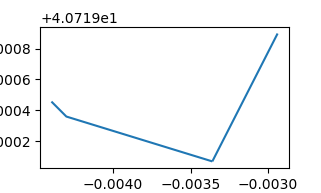

In [4]:
manhattan[manhattan["physicalid"].isin(["4040", "16696"])]["geometry"].plot()

In [5]:
a = manhattan[manhattan["physicalid"] == "4040"]["geometry"]
_, a_end = a.iloc[0].boundary

In [6]:
b = manhattan[manhattan["physicalid"] == "16696"]["geometry"]
b_end, _ = b.iloc[0].boundary

In [7]:
a_end.coords.xy == b_end.coords.xy

True

## Construct network

In [8]:
%run network.py

# coordinates of the intersections, stored as tuples
intersectionCoords = []
# format the coords as tuples
f = lambda x: (x.coords.xy[0][0], x.coords.xy[1][0])
# add unique elements to list
addToList = lambda x, lst: lst.append(x) if x not in lst else ()

for index, row in manhattan.iterrows():
    if row["trafdir"] != "NV":
        try:
            coord1, coord2 = row["geometry"].boundary
            addToList(f(coord1), intersectionCoords)
            addToList(f(coord2), intersectionCoords)
        except ValueError:
            pass

In [9]:
network = Network(intersectionCoords)

In [10]:
intersectionID = dict(zip(intersectionCoords, range(len(intersectionCoords))))
for index, row in manhattan.iterrows():
    if row["trafdir"] != "NV":
        try:
            coord1, coord2 = row["geometry"].boundary
            network.add_streets_from_nodes(intersectionID[f(coord1)],
                                           intersectionID[f(coord2)],
                                           row["trafdir"] == "TW")
        except ValueError:
            pass

<IPython.core.display.Javascript object>


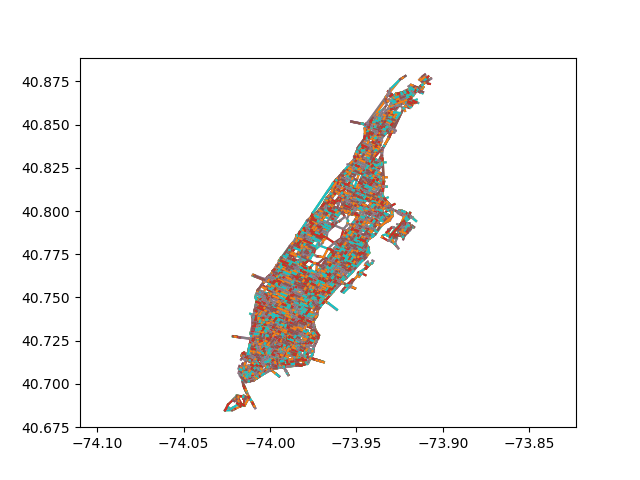

100%|██████████| 22462/22462 [08:48<00:00, 42.46it/s]


In [13]:
plt.figure()
plt.axis('equal')
for street in tqdm(network.streets):
    n1 = network.nodes[street.start]
    n2 = network.nodes[street.end]
    x1, y1 = n1.coord
    x2, y2 = n2.coord
    plt.plot([x1, x2], [y1, y2])

## Detect one way street

In [24]:
# Modified network

class Node():
    def __init__(self, coord, node_id, network):
        """
        Construct a Node object given a tuple of coordinates and id
        Inputs
        ------
        coord: a tuple of (lat, long) coordinate
        node_id: an int specifying an id
        network: parent network
        """
        self.coord = coord
        self.node_id = node_id
        self.starts, self.ends = [], []
        self.network = network

    def __repr__(self):
        x, y = self.coord
        return '<Node {}: ({}, {})>'.format(self.node_id, x, y)


class Street():
    def __init__(self, start_node_id, end_node_id, street_id, twoway, network):
        """
        Construct a Street object from the start_node to the end_node
        Inputs
        ------
        start_node: the starting Node
        end_node: the end Node
        id: int street_id
        twoway: boolean, whether the street is twoway
        network: parent network
        """
        self.street_id = street_id
        self.start = start_node_id
        self.end = end_node_id
        self.twoway = twoway
        self.network = network

    def __repr__(self):
        return '<Street {}: twoway = {}; from {} to {}>'\
                .format(self.street_id, self.twoway,
                    self.network.nodes[self.start],
                    self.network.nodes[self.end])


class NewNetwork():
    def __init__(self, coords):
        """
        Construct a Network object given a list of coords
        Inputs
        ------
        coords: a list of coordinates representing Nodes
        """
        self.this_node_id = 0
        self.nodes = []
        self.streets = []

        for coord in coords:
            node = Node(coord, self.this_node_id, self)
            self.nodes.append(node)
            self.this_node_id += 1

    def __add_street_to_node(self, node_id, street_id, ends_street):
        """
        Add a Street object to the Node
        Inputs
        ------
        node_id: the id of the Node for which the street is added to
        street_id: the id of the Street to the added to the Node
        ends_street: boolean, if True, then the Street added leads to the Node,
            otherwise, the Street added initiates from the Node
        """
        if ends_street:
            self.nodes[node_id].ends.append(street_id)
        else:
            self.nodes[node_id].starts.append(street_id)

    def __add_single_street(self, start_node_id, end_node_id, twoway, physical_id):
        """
        Add a Street object to the Network and related Nodes
        Inputs
        ------
        start_node_id: int, the id of the Node that starts the street
        end_node_id: int, the id of the Node that ends the street
        twoway: boolean, whether the street is a twoway street
        Returns
        ------
        street: Street object constructed
        """

        street = Street(start_node_id, end_node_id, physical_id, twoway, self)
        self.streets.append(street)
        self.__add_street_to_node(start_node_id, physical_id, False)
        self.__add_street_to_node(end_node_id, physical_id, True)

    def add_streets_from_nodes(self, node1_id, node2_id, twoway, physical_id):
        """
        Add two Streets from two nodes
        Inputs
        ------
        node1_id, node2_id : ids for nodes
        twoway: boolean, whether the street connecting the nodes is twoway
        Returns
        -----
        s1, s2: Streets constructed
        """
        if twoway:
            self.__add_single_street(node1_id, node2_id, twoway, physical_id)
            self.__add_single_street(node2_id, node1_id, twoway, physical_id)
        else:
            self.__add_single_street(node1_id, node2_id, twoway, physical_id)

    def get_node(self, lat, long):
        """
        Takes lat, long coordinates and returns the id of the closest node
        """
        dists = map(lambda node :
                    (node.coord[0] - lat) ** 2 + (node.coord[1] - long) ** 2,
                    self.nodes)
        return np.argmin(dists)

In [22]:
# a dictionary of the coordinates of intersections to the physical IDs
# of the streets that are connected to this intersection
intersectionToStreet = dict()

def addRecord(x, id_, dict_):
    try:
        dict_[f(x)].append(int(id_))
    except KeyError:
        dict_[f(x)] = [int(id_)]

for index, row in manhattan.iterrows():
    try:
        coord1, coord2 = row["geometry"].boundary
        addRecord(coord1, row["physicalid"], intersectionToStreet)
        addRecord(coord2, row["physicalid"], intersectionToStreet)
    except ValueError:
        pass

In [19]:
# test if for any street, we can find a connected street that is
# on the same line so that we can orient

good, bad = 0, 0
with tqdm(total=len(manhattan)) as pbar:
    for index, row in manhattan.iterrows():
        pbar.update(1)
        if row["trafdir"] in ["TF", "FT"]:
            try:
                mark = False
                coord1, coord2 = row["geometry"].boundary
                # search for connected streets that are on the same line
                for physicalID in intersectionToStreet[f(coord1)] + intersectionToStreet[f(coord2)]:
                    street = manhattan[manhattan["physicalid"] == physicalID].iloc[0]
                    if abs(int(street["physicalid"]) - physicalID) < 50:
                        mark = True
                        break
                good += mark
                bad += 1 - mark
            except ValueError:
                pass

100%|██████████| 13259/13259 [02:59<00:00, 73.98it/s] 


In [17]:
print("Number of one-way streets w/ connections:", good)
print("Number of one-way streets w/o connections:", bad)

Number of one-way streets w/ connections 8621
Number of one-way streets w/o connections 0


In [27]:
new_network = NewNetwork(intersectionCoords)

with tqdm(total=len(manhattan)) as pbar:
    for index, row in manhattan.iterrows():
        pbar.update(1)
        if row["trafdir"] in ["FT", "TF"]:
            try:
                coord1, coord2 = row["geometry"].boundary
                mark = False  # flag whether we have added the one-way street to the network
                # search for connected streets on the same line
                for physicalID in intersectionToStreet[f(coord1)]:
                    street = manhattan[manhattan["physicalid"] == str(physicalID)].iloc[0]
                    if abs(int(street["physicalid"]) - physicalID) < 50:
                        if (street["l_low_hn"] < row["l_low_hn"] and row["trafdir"] == "FT" or
                            street["l_low_hn"] > row["l_low_hn"] and row["trafdir"] == "TF"):
                            new_network.add_streets_from_nodes(intersectionID[f(coord1)],
                                                               intersectionID[f(coord2)],
                                                               False, row["physicalid"])
                        else:
                            new_network.add_streets_from_nodes(intersectionID[f(coord2)],
                                                               intersectionID[f(coord1)],
                                                               False, row["physicalid"])
                        mark = True
                        break
                if not mark:
                    for physicalID in intersectionToStreet[f(coord2)]:
                        street = manhattan[manhattan["physicalid"] == str(physicalID)].iloc[0]
                        if abs(int(street["physicalid"]) - physicalID) < 50:
                            if (street["l_low_hn"] < row["l_low_hn"] and row["trafdir"] == "FT" or
                                street["l_low_hn"] > row["l_low_hn"] and row["trafdir"] == "TF"):
                                new_network.add_streets_from_nodes(intersectionID[f(coord2)],
                                                                   intersectionID[f(coord1)],
                                                                   False, row["physicalid"])
                            else:
                                new_network.add_streets_from_nodes(intersectionID[f(coord1)],
                                                                   intersectionID[f(coord2)],
                                                                   False, row["physicalid"])
            except ValueError:
                pass
        elif row["trafdir"] == "TW":
            try:
                coord1, coord2 = row["geometry"].boundary
                new_network.add_streets_from_nodes(intersectionID[f(coord1)],
                                                   intersectionID[f(coord2)],
                                                   True, row["physicalid"])
            except ValueError:
                pass

100%|██████████| 13259/13259 [00:32<00:00, 408.76it/s]


<IPython.core.display.Javascript object>


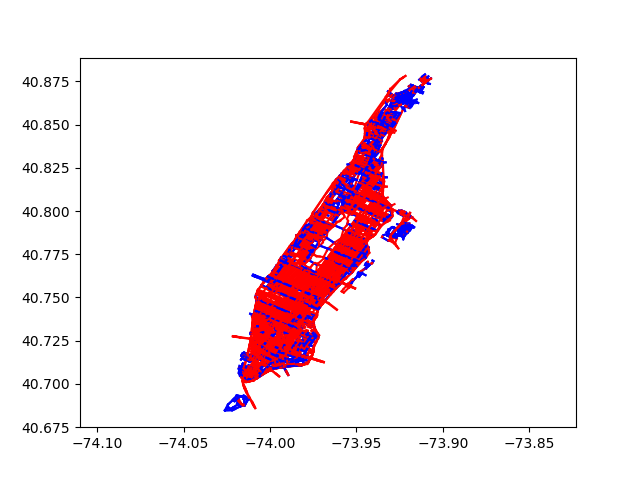

100%|██████████| 13841/13841 [03:13<00:00, 71.53it/s]


In [28]:
plt.figure()
plt.axis('equal')
for street in tqdm(new_network.streets):
    n1 = new_network.nodes[street.start]
    n2 = new_network.nodes[street.end]
    x1, y1 = n1.coord
    x2, y2 = n2.coord
    if street.twoway:
        plt.plot([x1, x2], [y1, y2], color="b")
    else:
        plt.plot([x1, x2], [y1, y2], color="r")